In [1]:
from os.path import join, isdir
from os import sep, getcwd, chdir
from ExperimentSettings import EXPERIMENT_SETTINGS
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Imports from parent directory
original_cur_dir = getcwd()
chdir('..')
from ResultsAnalyzer import ResultsAnalyzer
# Go back to current directory
chdir(original_cur_dir)

# General configuration

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
experiment_main_dir = 'Experiment'
anom_comm_names = [f'AnomComm000000000{str(i+1).zfill(2)}' for i in range(0, 10)]

In [5]:
res_analyzer = ResultsAnalyzer(experiment_main_dir, EXPERIMENT_SETTINGS, anom_comm_names)

# Meta-Features predictive ranking ability comparison

In [6]:
from ResultsAnalyzer import _ALL_PS, _ALL_SIZE_GROUPS, _ALL_MS
from tqdm.autonotebook import tqdm
output = []
for p in tqdm(_ALL_PS):
    for size_group in tqdm(_ALL_SIZE_GROUPS, leave=False):
        for m in _ALL_MS:
            exp_dir_path = res_analyzer._ordered_dir_paths[f'p{p:.2f}'][size_group][f'm{m:.2f}']

            results_analysis_df = res_analyzer.create_single_experiment_results_analysis_df(dir_path=exp_dir_path, algo='OurResults')
            results_analysis_dict = results_analysis_df.to_dict(orient='index')
            results_analysis_dict = {i+1: v for i,(k,v) in enumerate(results_analysis_dict.items())}

            scores_dict = {(p, size_group, m, k): v for k,v in results_analysis_dict.items()}
            map_scores_df = pd.DataFrame.from_dict(scores_dict, orient='index')
            map_scores_df = map_scores_df.reset_index().rename({
                'level_0': 'inter_p','level_1': 'comm_sizes', 'level_2': 'm', 'level_3': 'network_num'}, axis=1)

            map_scores_df['comm_sizes'] = pd.Categorical(
                map_scores_df['comm_sizes'],
                categories=['min', 'quantile10', 'quartile1', 'median', 'random'],
                ordered=True)
            map_scores_df = map_scores_df.sort_values('comm_sizes', inplace=False)
            output.append(map_scores_df)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
concat_scores = pd.concat(output)
concat_scores = concat_scores.drop(['weighted_sum'],axis=1)
concat_scores = concat_scores.set_index(['inter_p', 'comm_sizes', 'm', 'network_num'])

In [8]:
mapper = {
    'normality_prob_mean': '$EdgesNormalityMean$', 
    'normality_prob_std': '$EdgesNormalitySTDV$',
    'normality_prob_median': '$EdgesNormalityMedian$',
    'predicted_label_mean': '$PredictedEdgeLabelsMean$',
    'predicted_label_std': '$PredictedEdgeLabelsSTDV$'
}

concat_scores.rename(mapper, axis=1, inplace=True)

concat_scores = pd.DataFrame(concat_scores.stack()).reset_index()

In [9]:
concat_scores = concat_scores.rename({'level_4': 'meta_feature',0: 'avg_precision'}, axis=1)
concat_scores = concat_scores.rename(
    {
        'inter_p': '$inter\_p_{anom}$',
        'comm_sizes': '$comm\_sizes_{anom}$',
        'meta_feature': 'Meta-feature',
        'avg_precision': 'Average precision'}, axis=1
)



In [10]:
# Remove median
concat_scores = concat_scores.loc[concat_scores['Meta-feature']!='$EdgesNormalityMedian$']

<AxesSubplot:xlabel='$inter\\_p_{anom}$', ylabel='Average precision'>

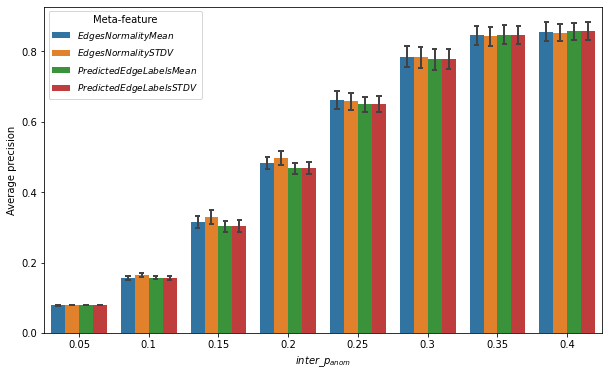

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(
    x='$inter\_p_{anom}$',
    y='Average precision',
    hue='Meta-feature',
    data=concat_scores,
    ax=ax,
    dodge=True, errwidth=2, capsize=0.05)

In [12]:
concat_scores.groupby('Meta-feature').aggregate({'Average precision': ['mean', 'median', 'std']})

Average precision             
                                       mean median   std
Meta-feature                                            
$EdgesNormalityMean$                  0.522  0.545 0.315
$EdgesNormalitySTDV$                  0.526  0.570 0.312
$PredictedEdgeLabelsMean$             0.518  0.537 0.314
$PredictedEdgeLabelsSTDV$             0.518  0.537 0.314

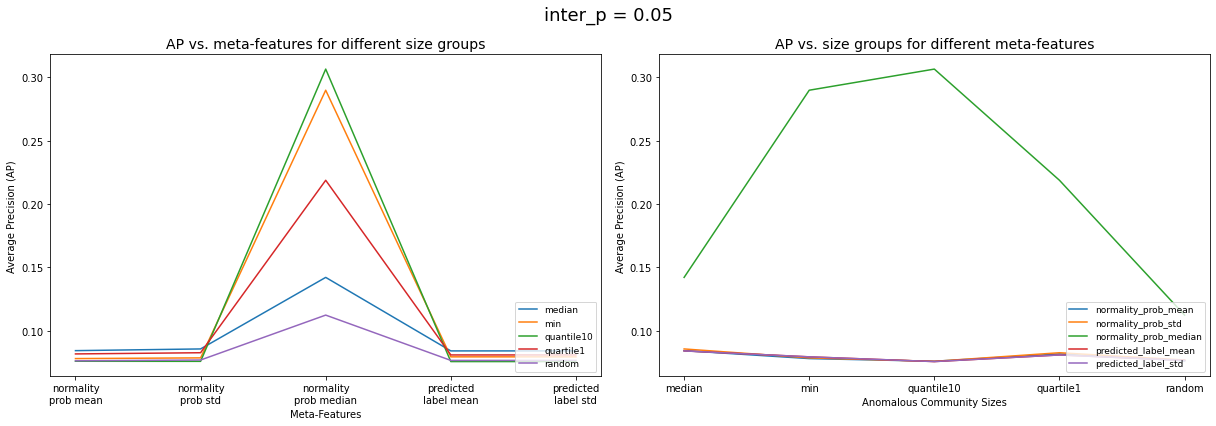

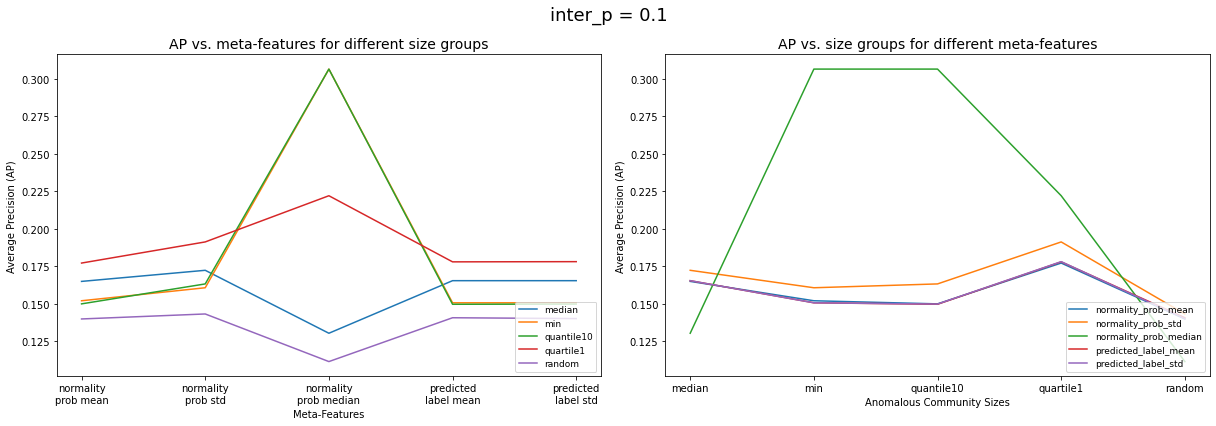

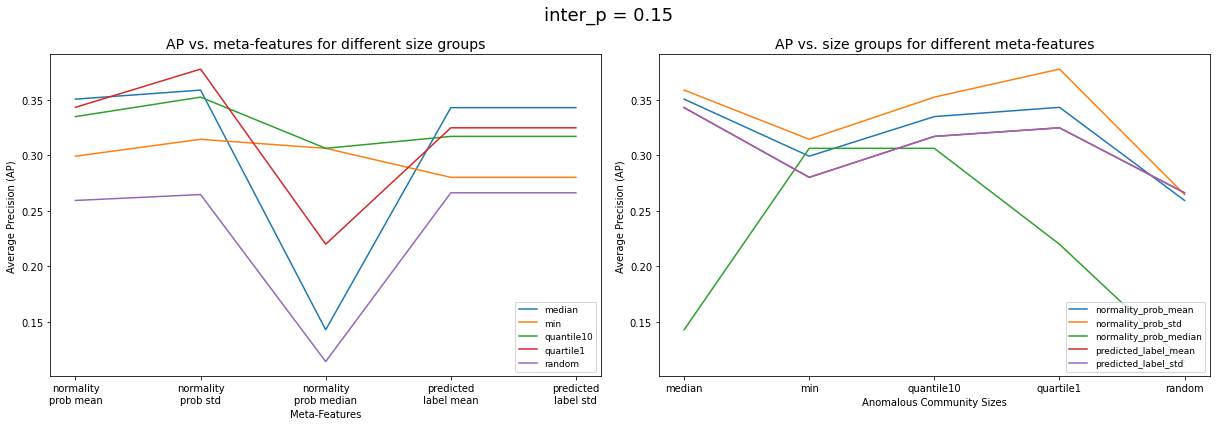

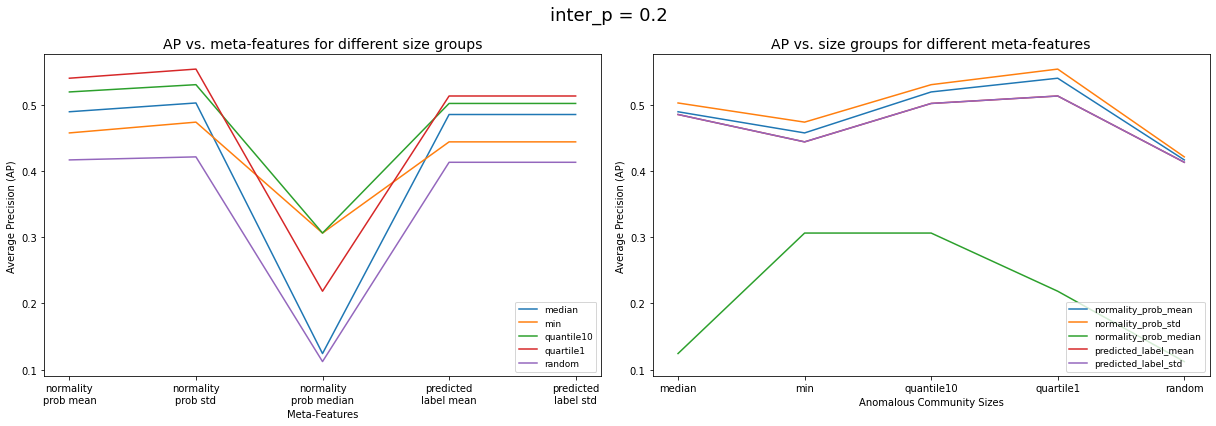

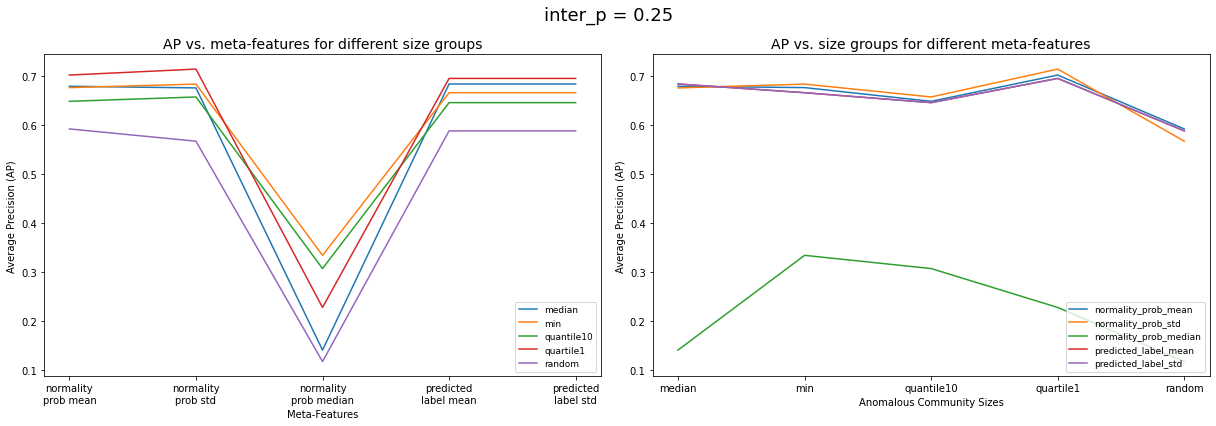

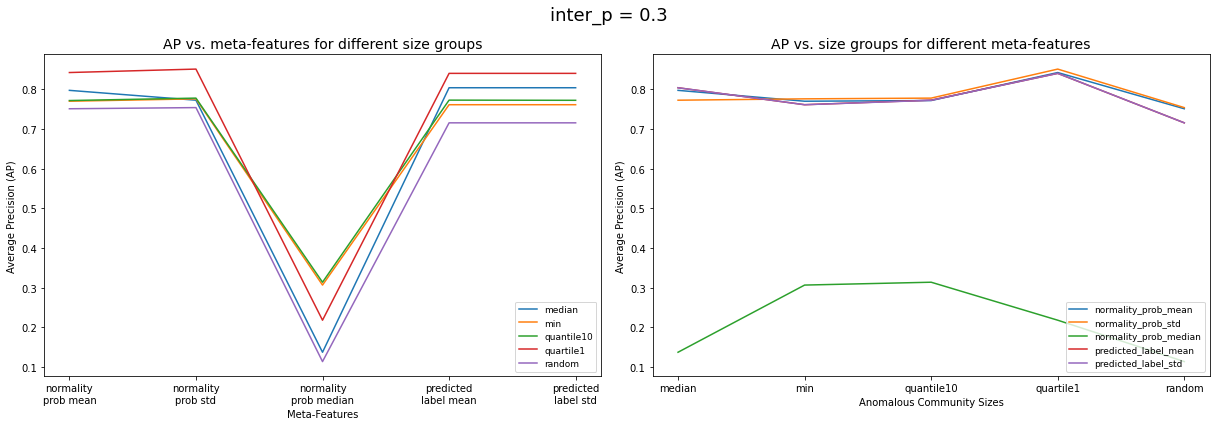

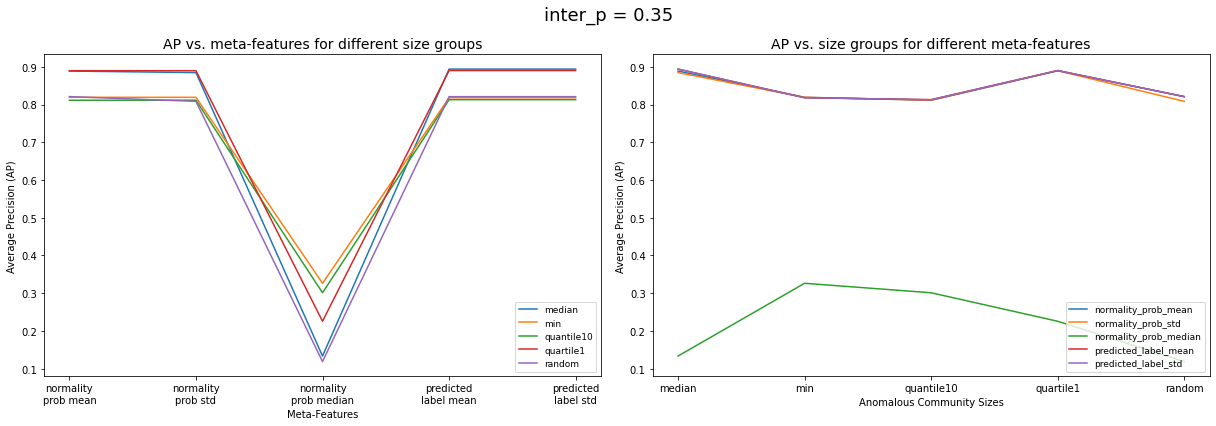

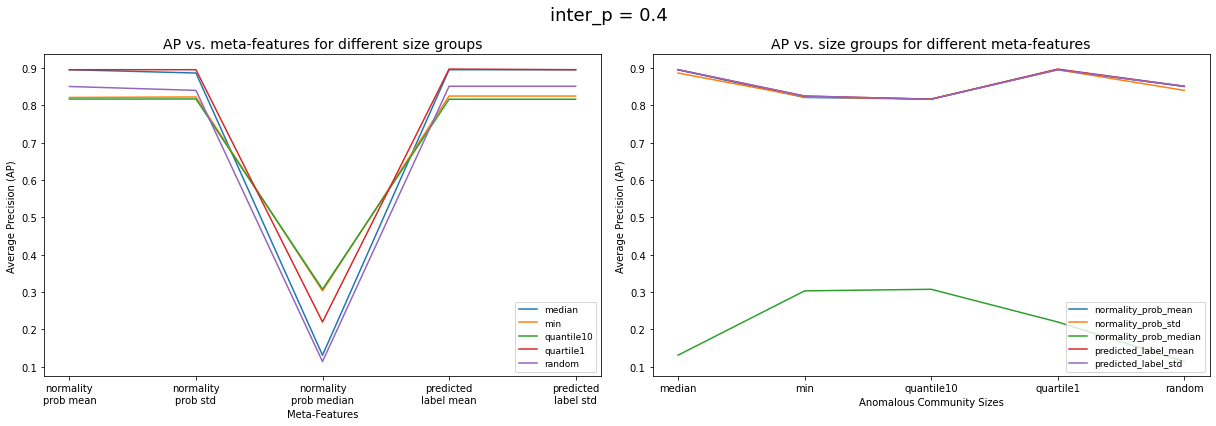

In [141]:
res_analyzer.plot_meta_features_comparison_grouped_by_ps_size_groups(skip_median=False)

In [144]:
meta_features_comparison_df = res_analyzer.get_meta_features_comparison_df()
meta_features_comparison_df

,normality_prob_mean,normality_prob_std,normality_prob_median,predicted_label_mean,predicted_label_std
anom_inter_p,,,,,
0.050,0.079,0.080,0.214,0.079,0.079
0.100,0.157,0.166,0.215,0.157,0.157
0.150,0.318,0.334,0.218,0.306,0.306
0.200,0.485,0.497,0.214,0.472,0.472
0.250,0.659,0.659,0.225,0.655,0.655
0.300,0.787,0.786,0.218,0.779,0.779
0.350,0.846,0.843,0.221,0.847,0.847
0.400,0.856,0.852,0.215,0.857,0.857


In [143]:
meta_features_comparison_df.describe().loc[['mean', '50%','std']].rename({'50%': 'median'})

,normality_prob_mean,normality_prob_std,normality_prob_median,predicted_label_mean,predicted_label_std
mean,0.523,0.527,0.217,0.519,0.519
median,0.572,0.578,0.216,0.563,0.563
std,0.311,0.307,0.004,0.312,0.312


normality_prob_std is the best meta-feature

# Evaluate with different parameters 

## Anom_inter_p

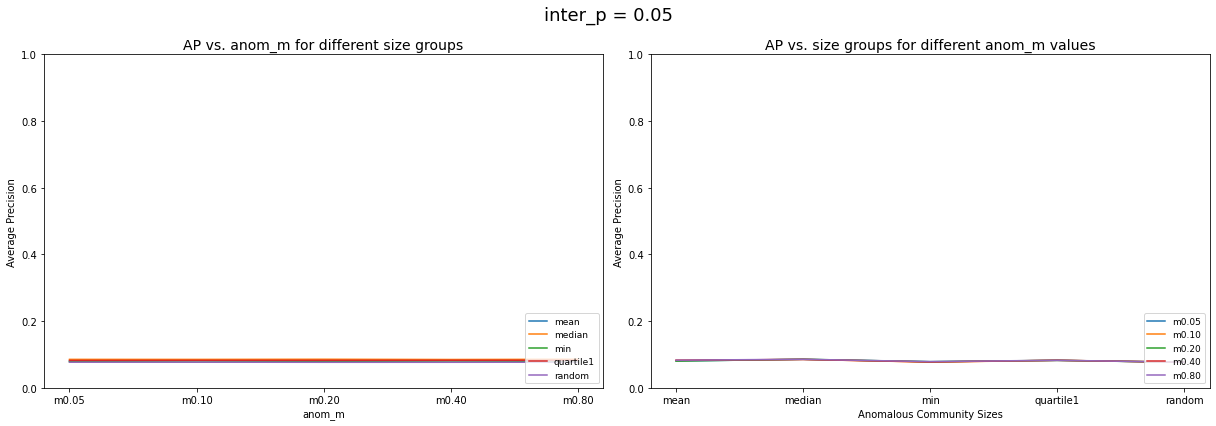

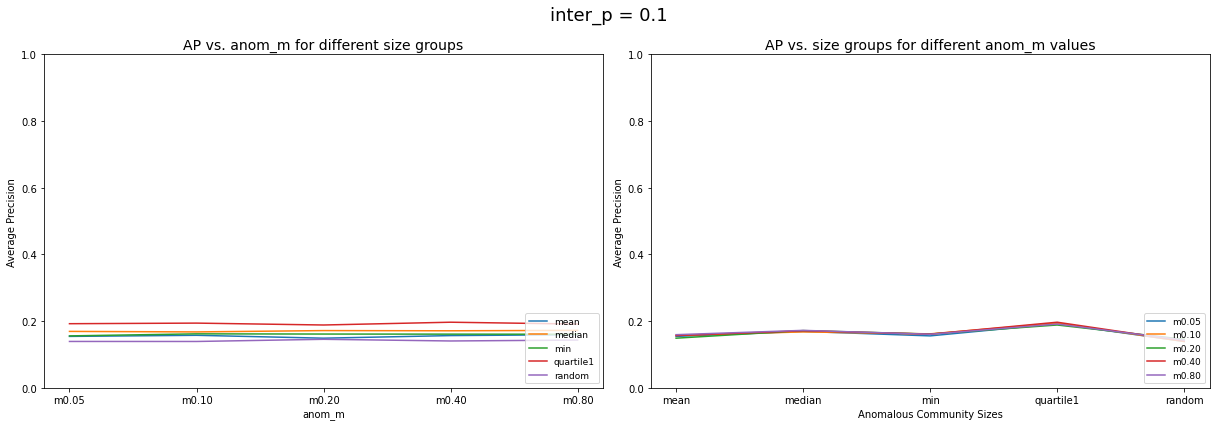

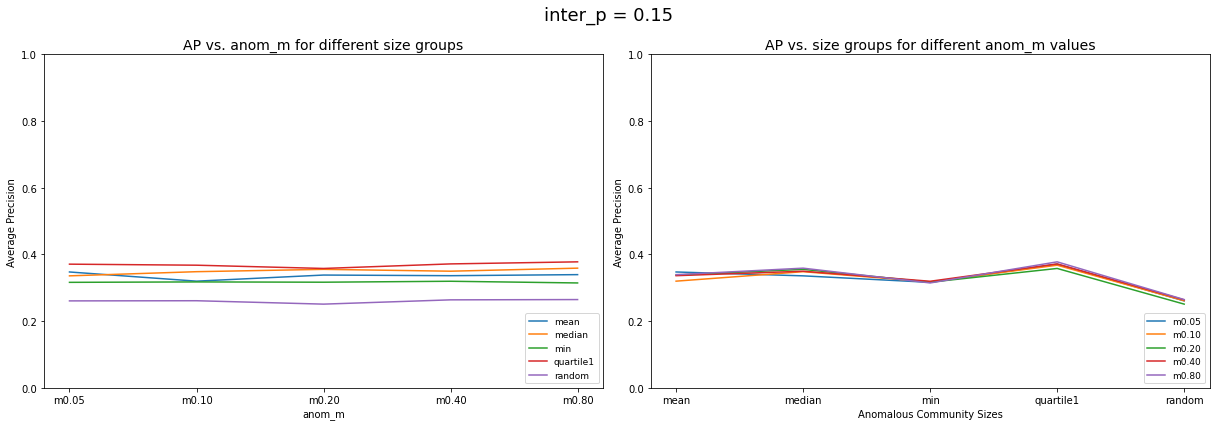

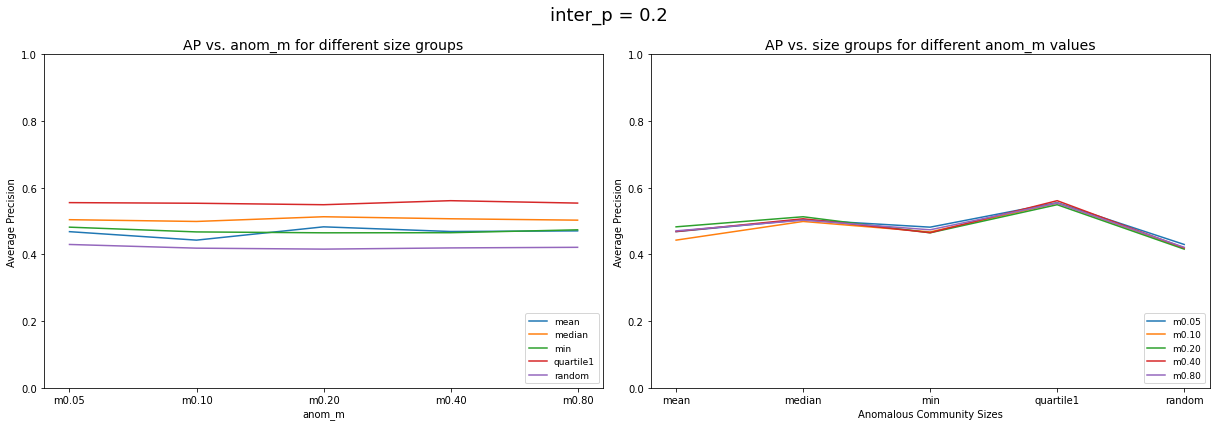

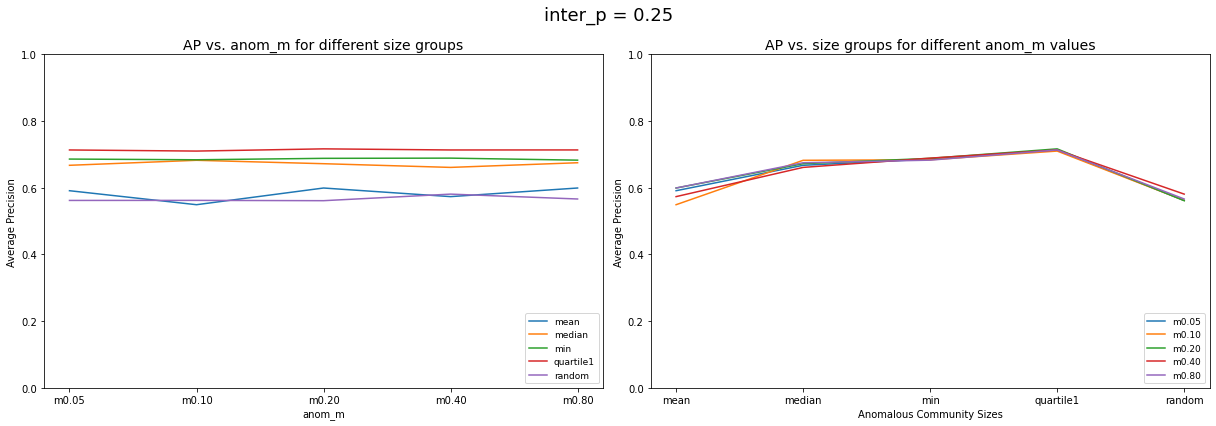

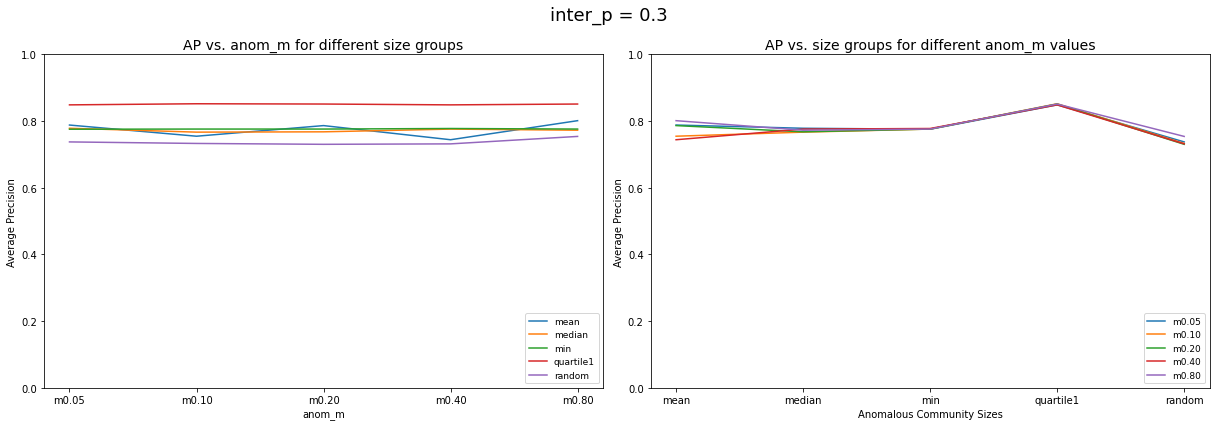

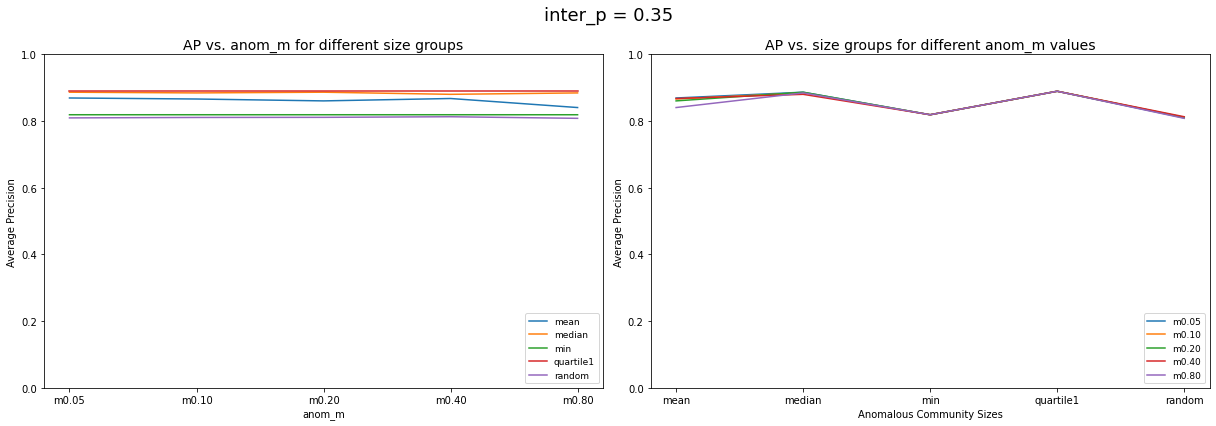

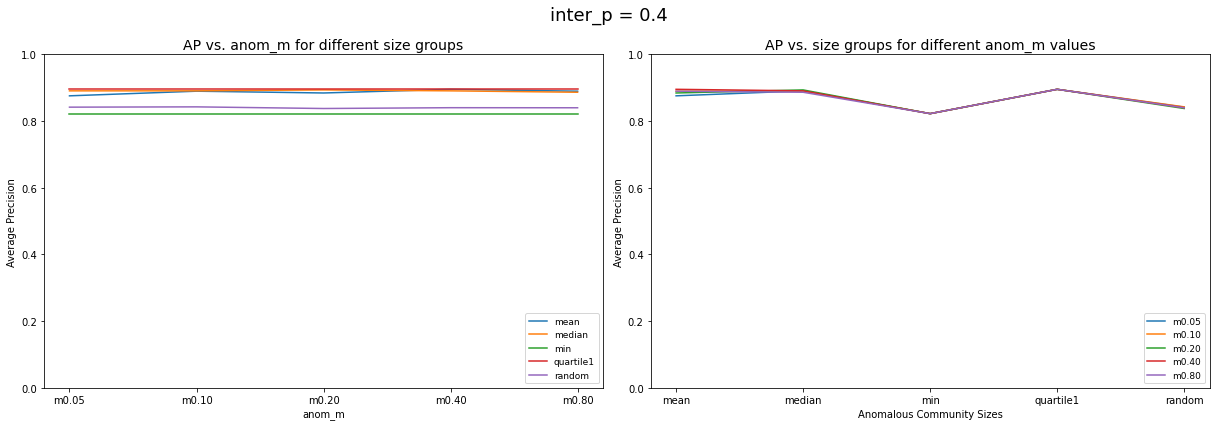

In [9]:
res_analyzer.plot_grouped_by_ps_ms_and_size_groups('normality_prob_std')

In [10]:
ps_comparison_df = res_analyzer.get_ps_comparison_df('normality_prob_std')
ps_comparison_df

,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4
size_group,,,,,,,,
min,0.078,0.160,0.317,0.471,0.686,0.776,0.819,0.822
quartile1,0.082,0.193,0.369,0.555,0.714,0.850,0.890,0.895
median,0.085,0.170,0.350,0.505,0.672,0.772,0.885,0.891
mean,0.082,0.155,0.336,0.467,0.583,0.775,0.861,0.887
random,0.077,0.141,0.260,0.421,0.567,0.737,0.811,0.841


In [11]:
ps_comparison_df.describe().loc[['mean', '50%','std']].rename({'50%': 'median'})

,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4
mean,0.081,0.164,0.326,0.484,0.644,0.782,0.853,0.867
median,0.082,0.160,0.336,0.471,0.672,0.775,0.861,0.887
std,0.004,0.019,0.042,0.050,0.065,0.041,0.037,0.033


## Anom_inter_m

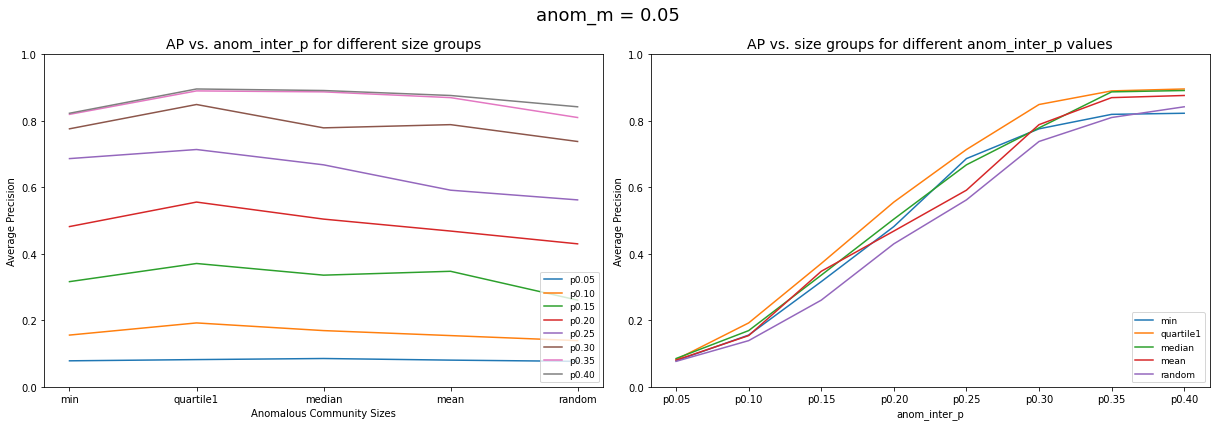

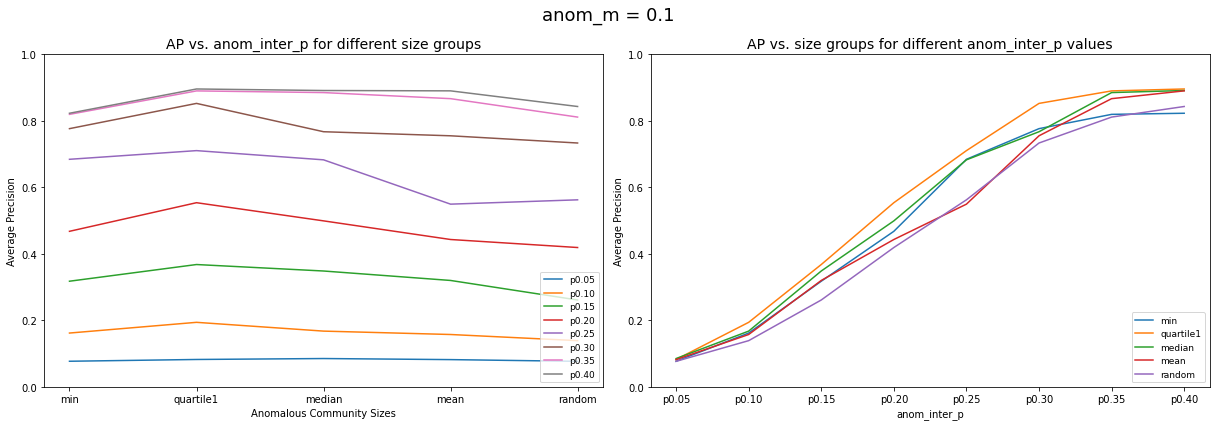

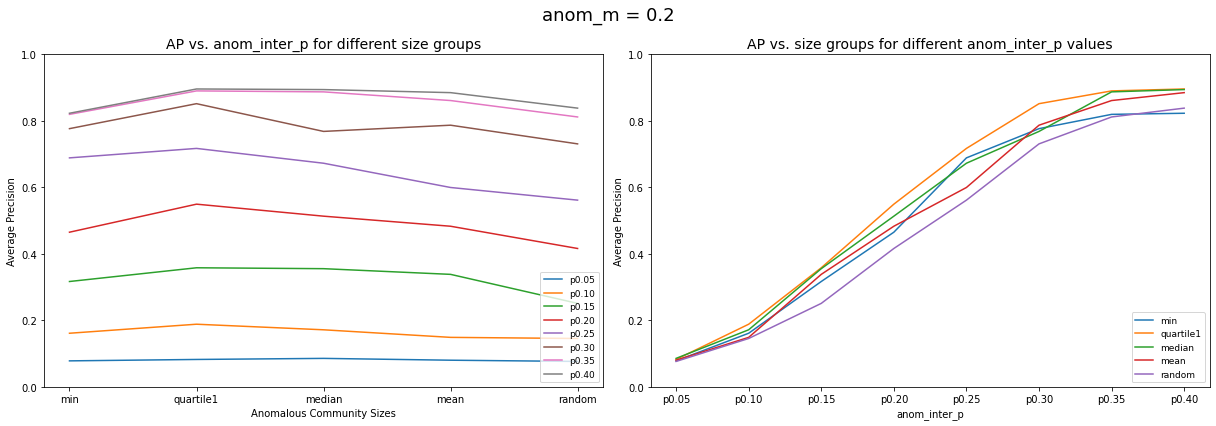

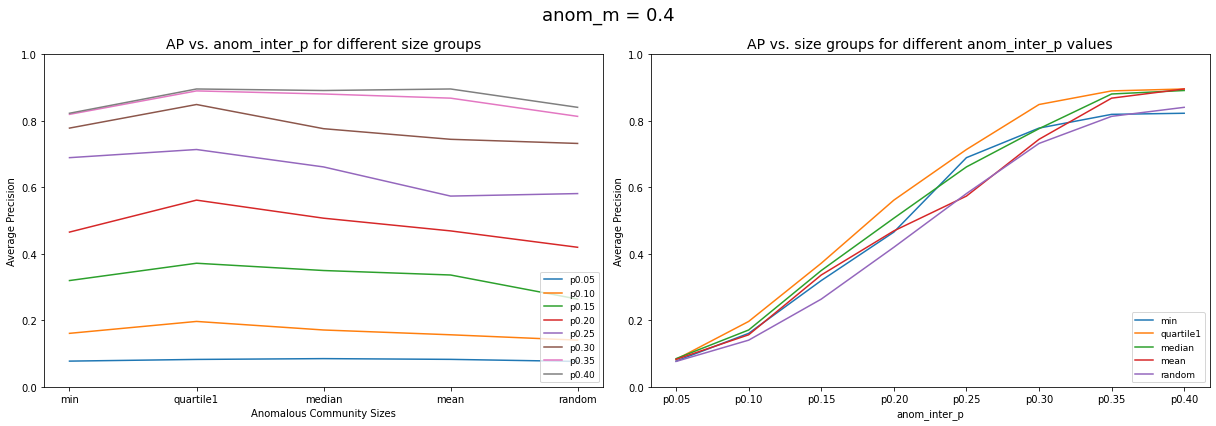

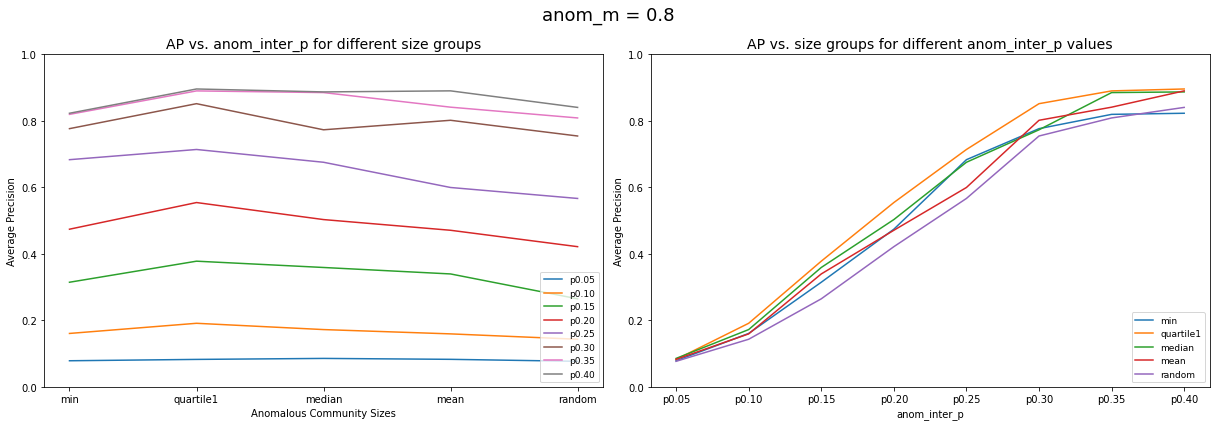

In [12]:
res_analyzer.plot_grouped_by_m_ps_and_size_groups('normality_prob_std')

In [13]:
ms_comparison_df = res_analyzer.get_ms_comparison_df('normality_prob_std')
ms_comparison_df

,0.05,0.1,0.2,0.4,0.8
anom_inter_p,,,,,
p0.05,0.081,0.081,0.081,0.081,0.081
p0.10,0.162,0.164,0.163,0.165,0.165
p0.15,0.326,0.323,0.324,0.328,0.331
p0.20,0.488,0.476,0.485,0.484,0.485
p0.25,0.644,0.638,0.648,0.644,0.647
p0.30,0.786,0.777,0.782,0.776,0.791
p0.35,0.855,0.854,0.854,0.854,0.849
p0.40,0.865,0.868,0.867,0.869,0.867


In [14]:
ms_comparison_df.describe().loc[['mean', '50%','std']].rename({'50%': 'median'})

,0.05,0.1,0.2,0.4,0.8
mean,0.526,0.523,0.525,0.525,0.527
median,0.566,0.557,0.566,0.564,0.566
std,0.311,0.310,0.311,0.310,0.310


## Size groups

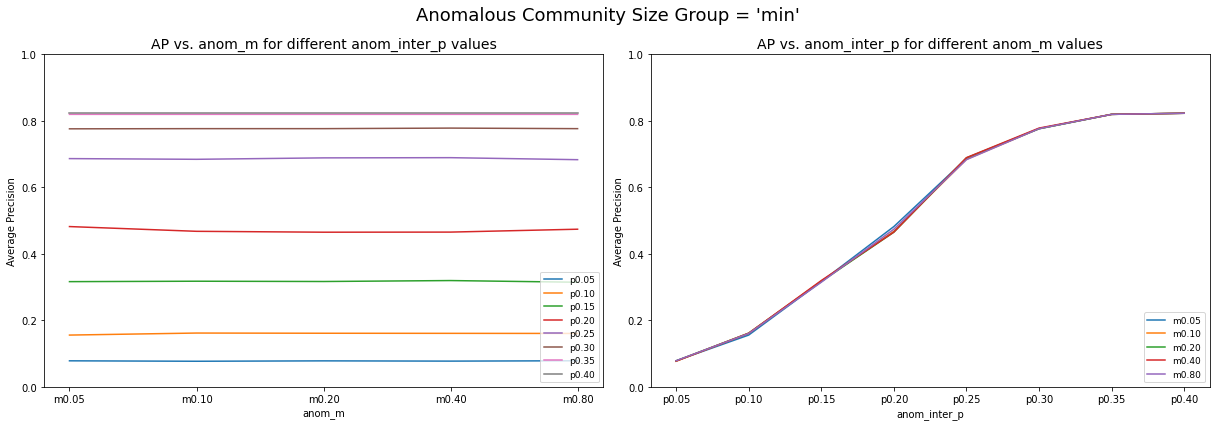

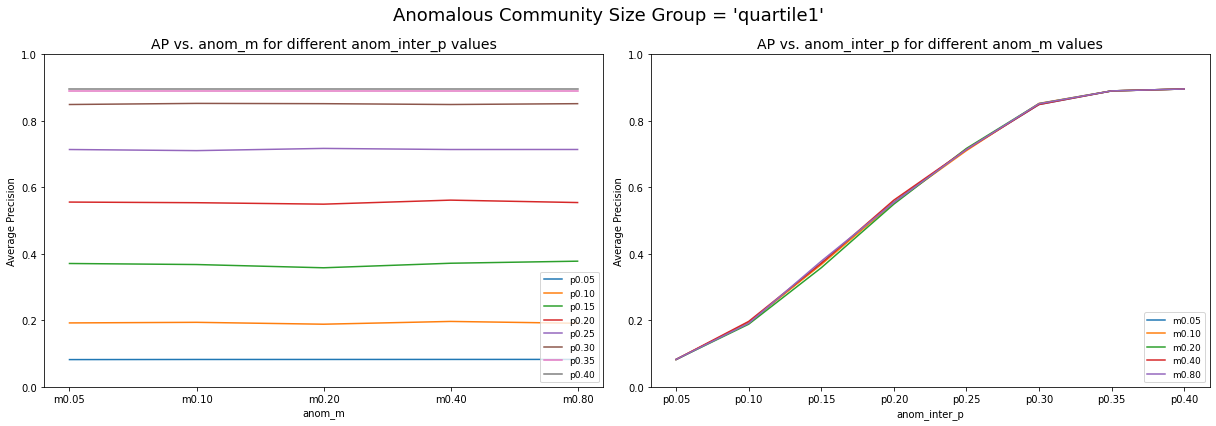

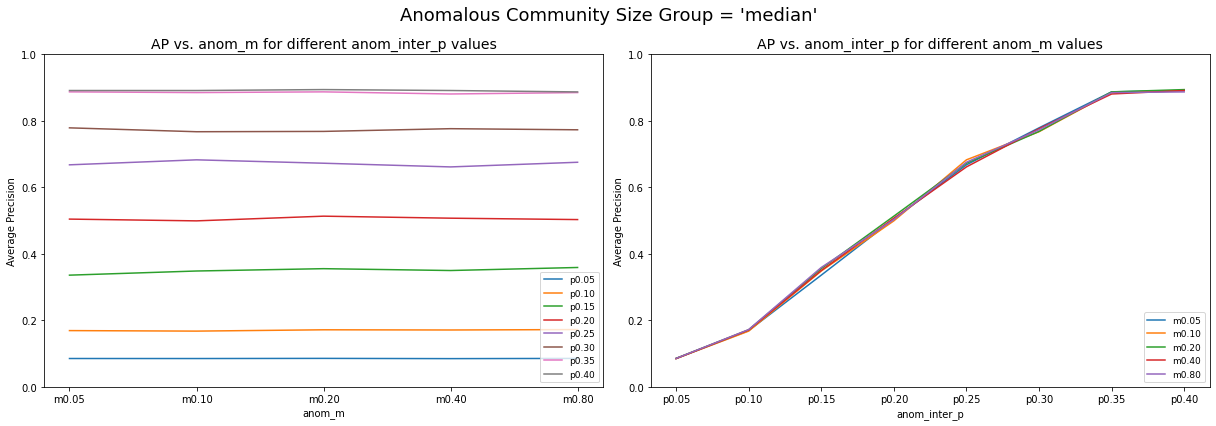

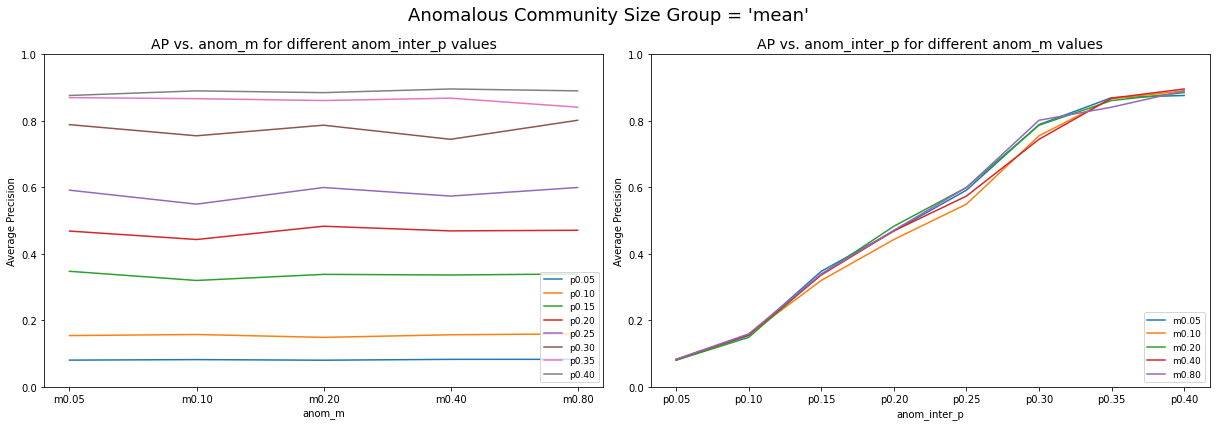

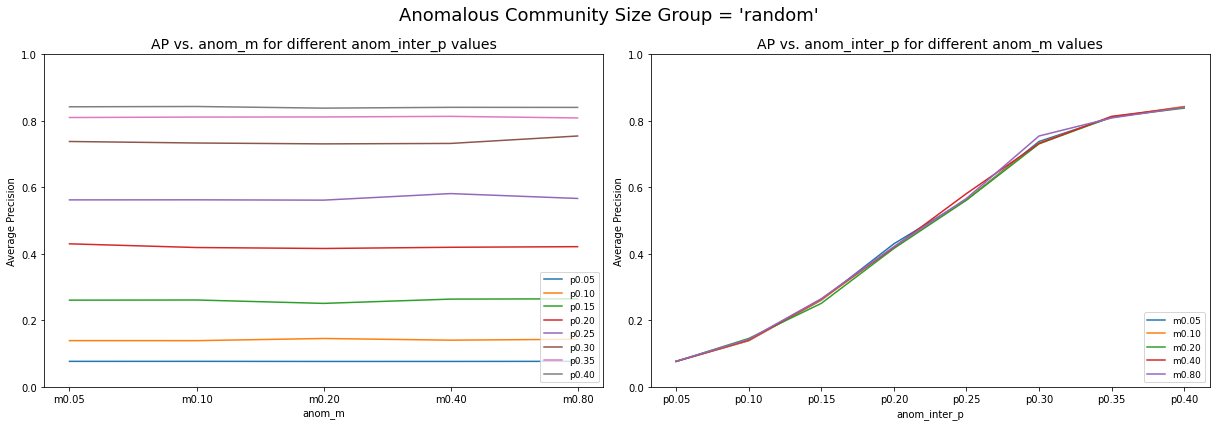

In [15]:
res_analyzer.plot_grouped_by_size_groups_ps_and_ms('normality_prob_std')

In [16]:
size_group_comparison_df = res_analyzer.get_size_groups_comparison_df('normality_prob_std')
size_group_comparison_df

,min,quartile1,median,mean,random
anom_m,,,,,
p0.05,0.078,0.082,0.085,0.082,0.077
p0.10,0.160,0.193,0.170,0.155,0.141
p0.15,0.317,0.369,0.350,0.336,0.260
p0.20,0.471,0.555,0.505,0.467,0.421
p0.25,0.686,0.714,0.672,0.583,0.567
p0.30,0.776,0.850,0.772,0.775,0.737
p0.35,0.819,0.890,0.885,0.861,0.811
p0.40,0.822,0.895,0.891,0.887,0.841


In [17]:
size_group_comparison_df.describe().loc[['mean', '50%','std']].rename({'50%': 'median'})

,min,quartile1,median,mean,random
mean,0.516,0.569,0.541,0.518,0.482
median,0.578,0.634,0.589,0.525,0.494
std,0.303,0.323,0.315,0.312,0.303
